In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pykrige.ok import OrdinaryKriging
from scipy.interpolate import griddata
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from geopy.geocoders import Nominatim
import numpy as np
import rasterio
from rasterio.transform import from_origin
from pykrige.ok import OrdinaryKriging
from scipy.stats import pearsonr

# Rurall - assignment

#### Import GPKG file in python
Below is a brief description of the attributes of the file:
- Longitudin/Latitudine geo-references of the acquisitions, CSR is in EPSG:4326
- RESAKG the amount of the product harvested acquired, in kg.
- VELOCITA, the speed of the harvester, in km/h.
- AREA, the area harvested since the last acquisition, in m 2 .
- UMIDITA, the average relative humidity of the product, in %.
- Longitudin e Latitudine: These are classical geographic coordinates in decimal degrees (EPSG:4326 - WGS84), used in GPS.
- Geometry:It is a special column in Shapely Point format, used by GeoPandas to manage spatial data in a more advanced way.


In [2]:
file_path = "resa_girasole_2022.gpkg"
file = gpd.read_file(file_path)
file.head()

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,NaN,POINT (1333142.685 5597543.903)
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,NaN,POINT (1333141.706 5597572.841)
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,NaN,POINT (1333141.672 5597604.934)
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.1,POINT (1333142.284 5597633.165)
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.1,POINT (1333142.195 5597662.213)


It is possible to convert geometry's epsg to WGS84 (lat/lon), to make the columns more consistent with Latitudine and Longitudin. What's called "WGS84" is usually a specific standard for lat-long, more formally called "EPSG Coordinate Reference System Code 4326".

In [3]:
print('Before:', file.crs)
file_dd = file.to_crs(epsg=4326)
print('After:', file_dd.crs)
file_dd.head()

Before: EPSG:3857
After: EPSG:4326


,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,"5 set 2022, 10:08:09","11,9758245","44,8474908",1870.0,4.80,140.000,NaN,POINT (11.97582 44.84749)
1,"5 set 2022, 10:08:24","11,9758157","44,8476751",1270.0,4.83,140.875,NaN,POINT (11.97582 44.84768)
2,"5 set 2022, 10:08:40","11,9758154","44,8478795",1420.0,4.78,139.417,NaN,POINT (11.97582 44.84788)
3,"5 set 2022, 10:08:55","11,9758209","44,8480593",2010.0,4.85,141.458,33.1,POINT (11.97582 44.84806)
4,"5 set 2022, 10:09:10","11,9758201","44,8482443",1320.0,4.80,140.000,33.1,POINT (11.97582 44.84824)


In [4]:
geolocator = Nominatim(user_agent="geoapi")
point = file_dd.geometry.iloc[0]  # Prendere il primo punto
location = geolocator.reverse((point.y, point.x), language="it")  # Inverti per lat/lon
print(location.address)

Via Cisi, Gherardi, Jolanda di Savoia, Ferrara, Emilia-Romagna, 44037, Italia


Adress: Via Cisi, Gherardi, Jolanda di Savoia, Ferrara, Emilia-Romagna, 44037, Italia

#### EDA

1. The data shall be treated to cleanse them for further processing (explain the steps
taken).

In [5]:
print('Number of duplicates:\n',file_dd.duplicated().sum())
print('Shape:\n',file_dd.shape)
print('General info:',file_dd.info)

Number of duplicates:
 0
Shape:
 (1962, 8)
General info: <bound method DataFrame.info of                   Data/Ora  Longitudin  Latitudine  RESAKG  VELOCITA     AREA  \
0     5 set 2022, 10:08:09  11,9758245  44,8474908  1870.0      4.80  140.000   
1     5 set 2022, 10:08:24  11,9758157  44,8476751  1270.0      4.83  140.875   
2     5 set 2022, 10:08:40  11,9758154  44,8478795  1420.0      4.78  139.417   
3     5 set 2022, 10:08:55  11,9758209  44,8480593  2010.0      4.85  141.458   
4     5 set 2022, 10:09:10  11,9758201  44,8482443  1320.0      4.80  140.000   
...                    ...         ...         ...     ...       ...      ...   
1957  3 set 2022, 20:13:03  11,9757431  44,8480422  2260.0      4.77  139.125   
1958  3 set 2022, 20:13:19  11,9757395  44,8482399  2460.0      4.78  139.417   
1959  3 set 2022, 20:13:34  11,9757408  44,8484282  2330.0      4.78  139.417   
1960  3 set 2022, 20:13:49  11,9757414   44,848618  1950.0      4.99  145.542   
1961  3 set 2022, 20

In [6]:
file_dd.describe()

,RESAKG,VELOCITA,AREA,UMIDITA
count,1962.000000,1962.000000,1962.000000,1925.000000
mean,2255.285423,4.903976,143.032629,27.022805
std,699.827651,0.614924,17.935293,6.154021
min,50.000000,0.780000,22.750000,18.600000
25%,1792.500000,4.570000,133.292000,22.200000
50%,2300.000000,4.900000,142.917000,25.800000
75%,2730.000000,5.180000,151.083000,30.200000
max,4880.000000,10.910000,318.208000,50.100000


We used a method called .describe() that summarize the central tendency, dispersion and shape of a dataset’s distribution of both numeric and object series.
- RESAKG: has a range of values from 50kg to 4880 kg, with a standard deviation of 701,2.
- VELOCITA: has a range of values from 0,78 km/h to 4880 km/h, with a standard deviation of 701,2.
- AREA: has a range of values from 50 m^2 to 4880m^2, with a standard deviation of 701,2.
- UMIDITA: has a range of values from 50% to 4880%, with a standard deviation of 701,2.
- Data/Ora: the range of date is 6 day, from 31st of August to 5th of September 2022.

In [7]:
filenew= file_dd.copy()
mean_value = filenew['UMIDITA'].mean() 
filenew['UMIDITA'].fillna(value=mean_value, inplace=True) 
print('Columns after replacing UMIDITA nan: \n',filenew.isna().sum())

Columns after replacing UMIDITA nan: 
 Data/Ora      0
Longitudin    0
Latitudine    0
RESAKG        0
VELOCITA      0
AREA          0
UMIDITA       0
geometry      0
dtype: int64


/var/folders/rb/qth463zd6lg3j7wzdyj2nc6h0000gn/T/ipykernel_49596/4138751435.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  filenew['UMIDITA'].fillna(value=mean_value, inplace=True)


Since the null values are almosto equal to 2% (37/1962) and being 'UMIDITA' a numeric variable, I decided to replace the rows with mean value. 

In [8]:
month_ita_to_eng = {
    "gen": "Jan", "feb": "Feb", "mar": "Mar", "apr": "Apr", "mag": "May",
    "giu": "Jun", "lug": "Jul", "ago": "Aug", "set": "Sep", "ott": "Oct", "nov": "Nov", "dic": "Dec"
}
for month_ita, month_eng in month_ita_to_eng.items():
    filenew["Data/Ora"] = filenew["Data/Ora"].str.replace(month_ita, month_eng)
filenew["Data/Ora"] = pd.to_datetime(filenew["Data/Ora"], format="%d %b %Y, %H:%M:%S")

To convert "Data/Ora" into datatime, it is necessary to translate months from Italian to English language.

### PLOT

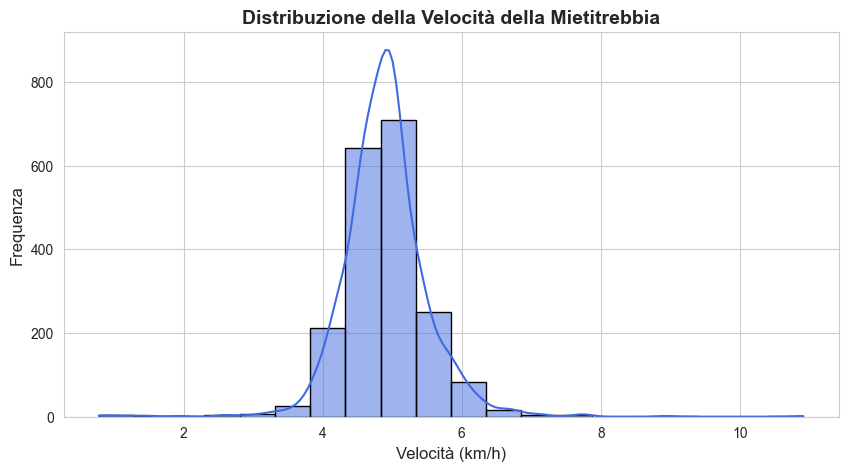

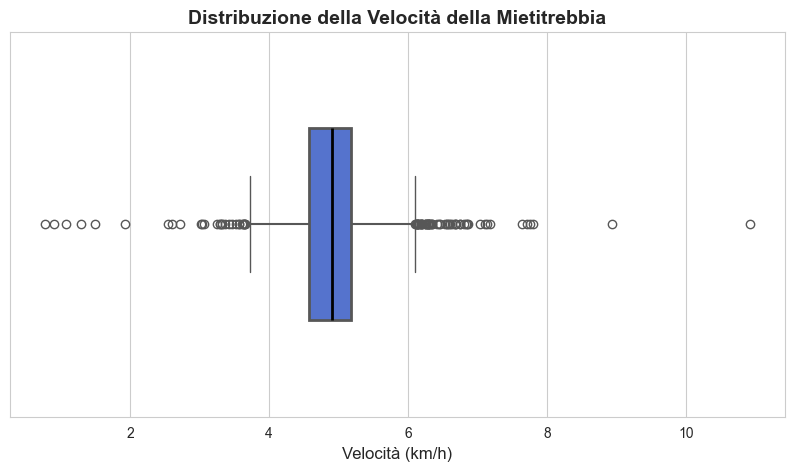

In [9]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(x=filenew["VELOCITA"], bins=20, kde=True, color="royalblue", edgecolor="black")
plt.title("Distribuzione della Velocità della Mietitrebbia", fontsize=14, fontweight='bold')
plt.xlabel("Velocità (km/h)", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.show()

sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.boxplot(x=filenew["VELOCITA"], color="royalblue", width=0.5, boxprops=dict(linewidth=2), 
            medianprops=dict(color="black", linewidth=2), whiskerprops=dict(linewidth=1.5))
plt.title("Distribuzione della Velocità della Mietitrebbia", fontsize=14, fontweight='bold')
plt.xlabel("Velocità (km/h)", fontsize=12)
plt.show()

Comment: \
Most of the observations are concentrated between about 4 and 6 km/h, indicating that this is the typical operational speed of the combine. The median (black line inside the box) is around 5 km/h, suggesting that half of the observations are below and half above this value.
Many outliers are present in both the lower (< 4 km/h) and upper (> 6 km/h) parts.
Some extreme values even exceed 10 km/h, which could indicate anomalies in the data or special collection conditions (e.g. terrain variations, vehicle manoeuvres, acquisition errors).

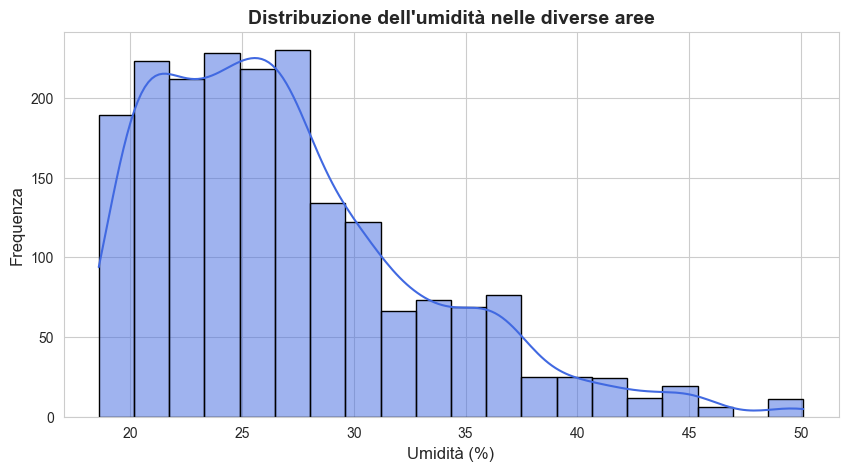

In [10]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(x=filenew["UMIDITA"], bins=20, kde=True, color="royalblue", edgecolor="black")
plt.title("Distribuzione dell'umidità nelle diverse aree", fontsize=14, fontweight='bold')
plt.xlabel("Umidità (%)", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.show()

Comments:

The distribution is skewed to the right, with most observations between 18% and 30% moisture, very high moisture values are less common.
The most frequently observed moisture seems to be around 25% to 27%, which could be the average moisture level of the crop in most of the areas analysed. There are a few observations with moisture values above 40% and 50%, although they are much less frequent, these values could be associated with special soil conditions or drainage problems in some parts of the field.

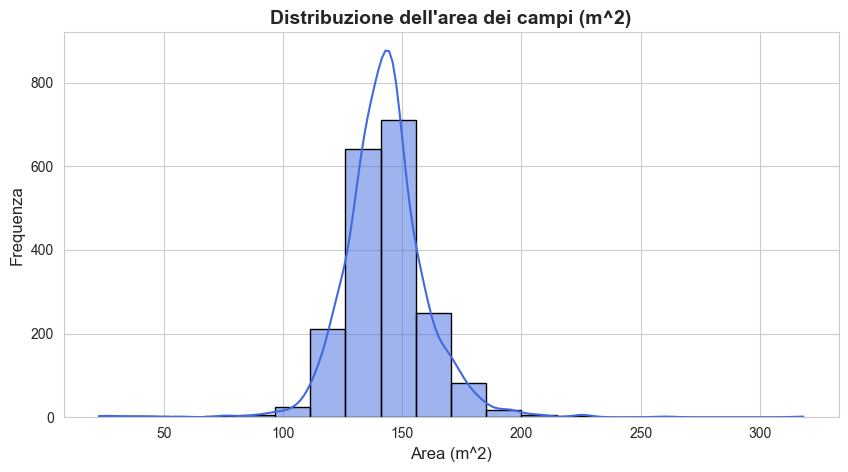

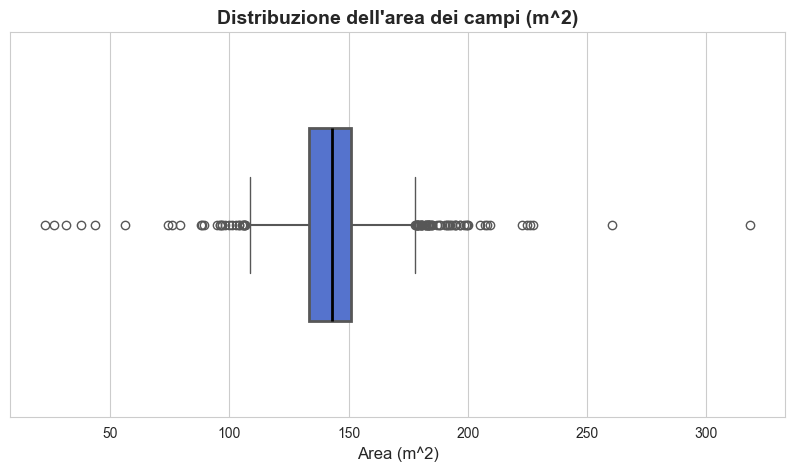

In [11]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(x=filenew["AREA"], bins=20, kde=True, color="royalblue", edgecolor="black")
plt.title("Distribuzione dell'area dei campi (m^2)", fontsize=14, fontweight='bold')
plt.xlabel("Area (m^2)", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.show()
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.boxplot(x=filenew["AREA"], color="royalblue", width=0.5, boxprops=dict(linewidth=2), 
            medianprops=dict(color="black", linewidth=2), whiskerprops=dict(linewidth=1.5))
plt.title("Distribuzione dell'area dei campi (m^2)", fontsize=14, fontweight='bold')
plt.xlabel("Area (m^2)", fontsize=12)
plt.show()

Comment: \
Most of the observations are concentrated between about 100 and 200 km, indicating that this is the typical range of area of a field. 
Many outliers are present in both the lower (< 100 km) and upper (> 200 km) parts.\
One extreme values even exceed 300 km. \
! Area distribution and Speed distribution are very similar.

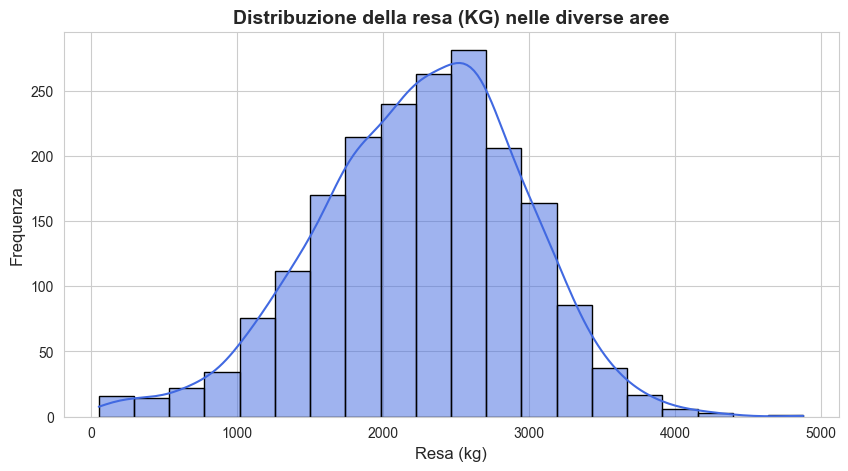

In [12]:
sns.set_style("whitegrid")
plt.figure(figsize=(10, 5))
sns.histplot(x=filenew["RESAKG"], bins=20, kde=True, color="royalblue", edgecolor="black")
plt.title("Distribuzione della resa (KG) nelle diverse aree", fontsize=14, fontweight='bold')
plt.xlabel("Resa (kg)", fontsize=12)
plt.ylabel("Frequenza", fontsize=12)
plt.show()

### DATE

In [13]:
df=filenew.copy()
df['Data/Ora'].value_counts()
df['Data/Ora'] = pd.to_datetime(df['Data/Ora'])
df['Data/Ora'] = df['Data/Ora'].dt.date
rows_per_day = df['Data/Ora'].value_counts().sort_index()
rows_per_day

Data/Ora
2022-08-31     190
2022-09-03    1455
2022-09-05     317
Name: count, dtype: int64

In [14]:
filenew

,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry
0,2022-09-05 10:08:09,"11,9758245","44,8474908",1870.0,4.80,140.000,27.022805,POINT (11.97582 44.84749)
1,2022-09-05 10:08:24,"11,9758157","44,8476751",1270.0,4.83,140.875,27.022805,POINT (11.97582 44.84768)
2,2022-09-05 10:08:40,"11,9758154","44,8478795",1420.0,4.78,139.417,27.022805,POINT (11.97582 44.84788)
3,2022-09-05 10:08:55,"11,9758209","44,8480593",2010.0,4.85,141.458,33.100000,POINT (11.97582 44.84806)
4,2022-09-05 10:09:10,"11,9758201","44,8482443",1320.0,4.80,140.000,33.100000,POINT (11.97582 44.84824)
...,...,...,...,...,...,...,...,...
1957,2022-09-03 20:13:03,"11,9757431","44,8480422",2260.0,4.77,139.125,30.800000,POINT (11.97574 44.84804)
1958,2022-09-03 20:13:19,"11,9757395","44,8482399",2460.0,4.78,139.417,24.600000,POINT (11.97574 44.84824)
1959,2022-09-03 20:13:34,"11,9757408","44,8484282",2330.0,4.78,139.417,24.600000,POINT (11.97574 44.84843)
1960,2022-09-03 20:13:49,"11,9757414","44,848618",1950.0,4.99,145.542,24.600000,POINT (11.97574 44.84862)


Data are taken in three different days, according to the previuos results  the data collect the 3rd of Seprember are the 74% of the total.

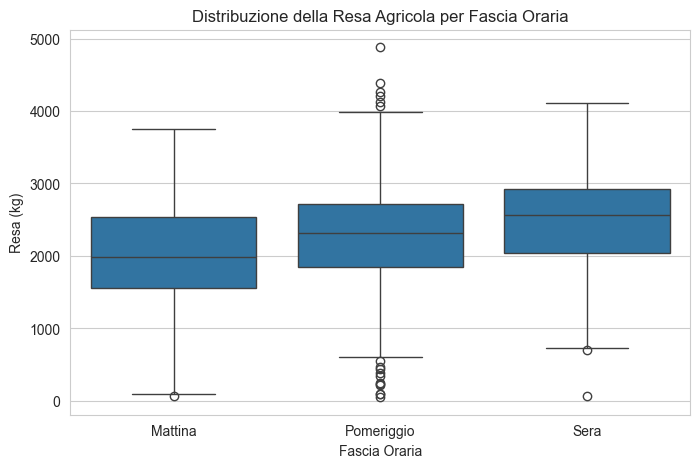

                count         mean         std   min     25%     50%     75%  \
Fascia Oraria                                                                  
Mattina         377.0  1987.824934  768.155459  70.0  1560.0  1980.0  2540.0   
Pomeriggio     1219.0  2276.964725  658.954220  50.0  1850.0  2310.0  2710.0   
Sera            366.0  2458.579235  676.422218  70.0  2040.0  2570.0  2917.5   

                  max  
Fascia Oraria          
Mattina        3750.0  
Pomeriggio     4880.0  
Sera           4110.0  


In [15]:
df1=filenew.copy()
df1["Ora"] = df1["Data/Ora"].dt.hour
def categorizza_fascia_oraria(ora):
    if 6 <= ora < 12:
        return "Mattina"
    elif 12 <= ora < 18:
        return "Pomeriggio"
    else:
        return "Sera"
df1["Fascia Oraria"] = df1["Ora"].apply(categorizza_fascia_oraria)
statistiche_resa = df1.groupby("Fascia Oraria")["RESAKG"].describe()
plt.figure(figsize=(8,5))
sns.boxplot(x="Fascia Oraria", y="RESAKG", data=df1, order=["Mattina", "Pomeriggio", "Sera"])
plt.title("Distribuzione della Resa Agricola per Fascia Oraria")
plt.xlabel("Fascia Oraria")
plt.ylabel("Resa (kg)")
plt.show()
print(statistiche_resa)

In [16]:
df1.dtypes

Data/Ora         datetime64[ns]
Longitudin               object
Latitudine               object
RESAKG                  float64
VELOCITA                float64
AREA                    float64
UMIDITA                 float64
geometry               geometry
Ora                       int32
Fascia Oraria            object
dtype: object

The distribution of agricultural yield by time slot shows some significant differences between morning, afternoon and evening.

- Morning: has the lowest average yield (1987 kg) and greater variability, with some very low values ​​(outliers).
- Afternoon: the average yield is higher (2277 kg) than in the morning and has a more concentrated distribution around the median value (2310 kg).
- Evening: shows the highest average yield (2459 kg) and lower dispersion, with values ​​on average higher than the other time slots.

The analysis suggests that yield tends to increase throughout the day, with more stable and higher values ​​in the evening. Outliers indicate that there may be particular conditions that significantly lower production in some situations.

In [17]:
df1['Fascia Oraria cat']=df1['Fascia Oraria'].replace({'Mattina':1,'Pomeriggio':2,'Sera':3})
df1.head()

/var/folders/rb/qth463zd6lg3j7wzdyj2nc6h0000gn/T/ipykernel_49596/46794090.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['Fascia Oraria cat']=df1['Fascia Oraria'].replace({'Mattina':1,'Pomeriggio':2,'Sera':3})


,Data/Ora,Longitudin,Latitudine,RESAKG,VELOCITA,AREA,UMIDITA,geometry,Ora,Fascia Oraria,Fascia Oraria cat
0,2022-09-05 10:08:09,"11,9758245","44,8474908",1870.0,4.80,140.000,27.022805,POINT (11.97582 44.84749),10,Mattina,1
1,2022-09-05 10:08:24,"11,9758157","44,8476751",1270.0,4.83,140.875,27.022805,POINT (11.97582 44.84768),10,Mattina,1
2,2022-09-05 10:08:40,"11,9758154","44,8478795",1420.0,4.78,139.417,27.022805,POINT (11.97582 44.84788),10,Mattina,1
3,2022-09-05 10:08:55,"11,9758209","44,8480593",2010.0,4.85,141.458,33.100000,POINT (11.97582 44.84806),10,Mattina,1
4,2022-09-05 10:09:10,"11,9758201","44,8482443",1320.0,4.80,140.000,33.100000,POINT (11.97582 44.84824),10,Mattina,1


### CORRELATION

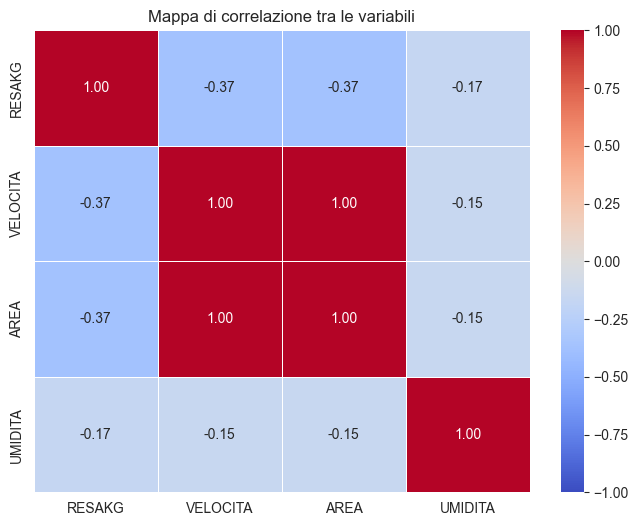

In [18]:
heat_col=df1[['RESAKG', 'VELOCITA', 'AREA',
       'UMIDITA']]
corr_matrix = heat_col.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)
plt.title("Mappa di correlazione tra le variabili")
plt.show()

The heatmap shows the correlation between the variables : \
- Yield (RESAKG) and Speed (-0.37) → Negative correlation: it means that as the speed of the combine increases, the yield tends to decrease. This could indicate that excessive speed compromises harvesting efficiency.
- Yield (RESAKG) and Moisture (-0.17) → Negative but weaker correlation: Moisture could influence yield, but the impact is not very strong.
- Speed and Moisture (-0.15) → Very low negative correlation: it seems that the speed of the combine is not much affected by the moisture of the crop.
- Speed and Area (1.00) → This value seems anomalous, as it suggests a perfect correlation. It could result from a feature of the dataset or a problem in the data recording.\
- UMIDITA and Fascia oraria (-0.28)→ Negative correlation: it means that as the evening comes, humidity tends to decrease.
- Yield (RESAKG) and Fascia oraria (0.21)→ Positive correlation: it means that as the evening comes, the yield tends to increase.
Harvester speed appears to be a critical factor in crop yield, with a clear negative impact.\
Let's plot this relation:

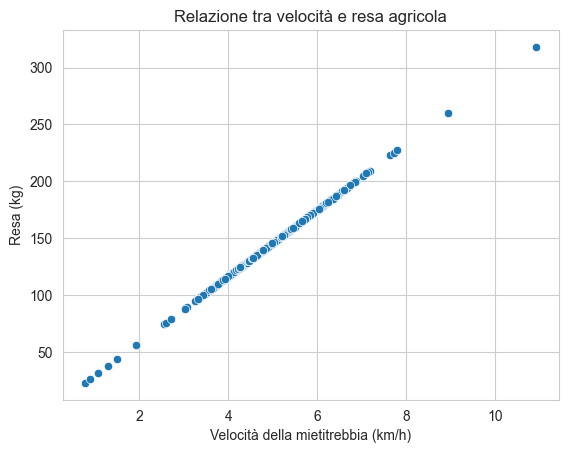

In [19]:
sns.scatterplot(x=df1["VELOCITA"], y=df1["AREA"])
plt.xlabel("Velocità della mietitrebbia (km/h)")
plt.ylabel("Resa (kg)")
plt.title("Relazione tra velocità e resa agricola")
plt.show()

Comment:
1. If the combine works faster, it covers a larger area and therefore collects more product.
2. There may be an optimal speed threshold beyond which the yield begins to decrease (to be verified with more data).

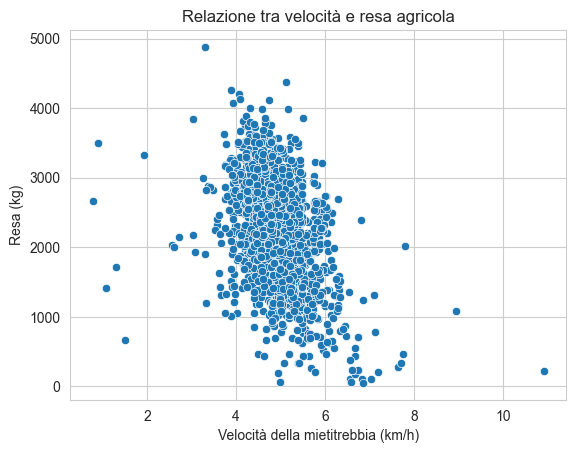

In [20]:
sns.scatterplot(x=df1["VELOCITA"], y=df1["RESAKG"])
plt.xlabel("Velocità della mietitrebbia (km/h)")
plt.ylabel("Resa (kg)")
plt.title("Relazione tra velocità e resa agricola")
plt.show()

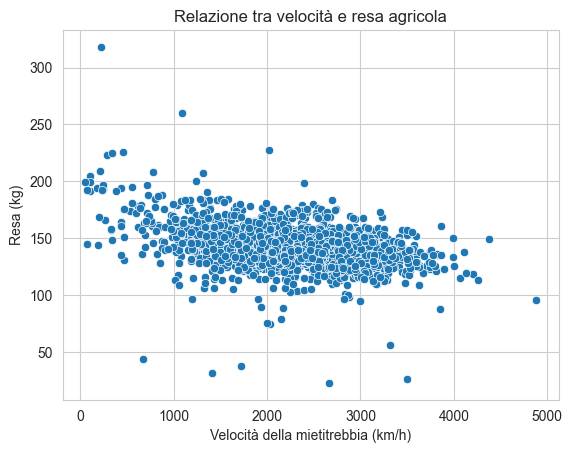

In [21]:
sns.scatterplot(x=df1["RESAKG"], y=df1["AREA"])
plt.xlabel("Velocità della mietitrebbia (km/h)")
plt.ylabel("Resa (kg)")
plt.title("Relazione tra velocità e resa agricola")
plt.show()

The relationship between area and crop yield shows a general trend in which yield decreases as speed increases. Some outliers indicate that very low or very high yields occur in rare cases. Maybe a faster combine harvester does its job less precisely and leads to a loss of yield.

### Interpolazione geospaziale

2. Spatially interpolate the resulted data (explain the algorithm/s used, input data format,
output data format).

In [22]:
x = df1.geometry.x
y = df1.geometry.y
z = df1["RESAKG"]
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]
grid_z = griddata((x, y), z, (grid_x, grid_y), method='cubic')

Create a grid using longitude and latitude info from geometry, that could be use as a map to interpolate the value such as yield for that space which wasn't include into the intial dataset.

Some common algorithms for doing this are:
- Kriging → an advanced method that takes into account the spatial variability of the data.
- IDW (Inverse Distance Weighting) → assigns a greater weight to the closest points to estimate intermediate values.-
- Griddata (SciPy) → uses methods such as nearest-neighbor, linear or cubic to interpolate a surface from point data.

Data Format:
Input: file with coordinates (Lat, Long) + RESAKG.
Output: a raster map or regular grid with interpolated yield values. It can be saved as GeoTIFF or CSV with regular coordinates.

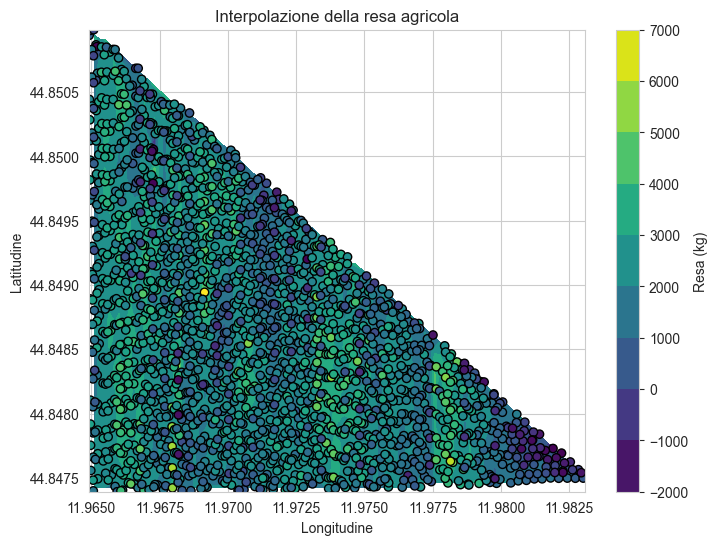

In [23]:
plt.figure(figsize=(8,6))
plt.contourf(grid_x, grid_y, grid_z, cmap='viridis')
plt.colorbar(label="Resa (kg)")
plt.scatter(x, y, c=z, cmap='viridis', edgecolors='k', marker='o')
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
plt.title("Interpolazione della resa agricola")
plt.show()

Create a plot to visualize the possible value of yield of datapoint that wasn't tracked.

In [ ]:
OK = OrdinaryKriging(x, y, z, variogram_model="spherical")
z_pred, ss = OK.execute("grid", grid_x, grid_y)
pixel_size_x = (max(x) - min(x)) / 100
pixel_size_y = (max(y) - min(y)) / 100
transform = from_origin(min(x), max(y), pixel_size_x, pixel_size_y)

with rasterio.open( #use rasterio cause create raster (type of date readble in GIS) could handle imagine int TIFF format
    "kriging_output.tif", "w",
    driver="GTiff",
    height=100, width=100,
    count=1, dtype="float32",
    crs="EPSG:4326",  # system
    transform=transform
) as dst:
    dst.write(z_pred.astype(np.float32), 1)

print("File GeoTIFF correctly create with georeferantiation.")

There are more differents algorithm used to spatially interpolate the data. 
I will use the Kriging method, an advanced spatial interpolation method that not only averages nearby values, but attempts to minimize the error using a mathematical function based on the variation in the data. 
Now we will create a continuous map of crop yield, estimating the values ​​at each point of the grid. (The same can be done for speed, area and moisture). \
Commenting on the steps one by one:
- **X** and **Y** are the geographic coordinates of the collected points.
- **Z** is our variable of interest (the agricultural yield).
- **gridx** and **gridy **create a grid of 100×100 points on which we estimate new values.
- **Ordinary Kriging**: assumes that the mean values of the data do not change in space, but considers their spatial correlation.
- **Variogram**: measures the correlation between nearby points to estimate new values. Variogram Model="spherical" uses a mathematical function that considers the distance between points. It is one of the most widely used models in agriculture and geostatistics, which indicates that neighbouring points have similar values, but beyond a certain distance the relationship between them gradually decreases.
- As INPUT for the model we have the coordinates and the yield's value.
- **z_pred** contains the interpolated values of agricultural yield.
- **ss** is the error for each estimation
- **Count=1** the raster has only one channel (a single variable: the rendering)
- **dtype="float32"**  values are decimal numbers.
- **crs="EPSG:4326"**  specifies the Coordinate Reference System (CRS)
- **EPSG:4326** is the WGS84 coordinate system (latitude and longitude, the same used by GPS).
- **transform=transform**  assigns the correct coordinates to each pixel.
- **dst.write(z_pred.astype(np.float32), 1)**  writes the interpolated data to the raster.
- OUTPUT: we have obtained a raster map with estimated values of the agricultural yield at each point of the field! "kriging_output.tif" → creates a raster file in GeoTIFF format.

A raster is an image composed of a grid of cells (pixels), where each pixel contains a numerical value.
In our case, the pixels contain the yield estimated by Kriging.


OUTPUT:\
Saves the result of the Kriging interpolation as a raster file in GeoTIFF format
The kriging_output.tif file will be a geospatial map of the estimated yield, which can be used in GIS software such as QGIS, ArcGIS or in geospatial analysis with raster and geopandas.

It can be overlaid on satellite maps to analyse the distribution of agricultural yield better and it is useful for comparing with other geospatial layers (moisture, soil type, etc.).

In [1]:
plt.figure(figsize=(10, 6))
plt.imshow(z_pred, extent=(min(x), max(x), min(y), max(y)), origin="lower", cmap="viridis")
plt.colorbar(label="Resa stimata (kg)")
plt.scatter(x, y, c=z, edgecolors="black", cmap="coolwarm", label="Punti misurati")
plt.title("Interpolazione della resa agricola con Kriging")
plt.xlabel("Longitudine")
plt.ylabel("Latitudine")
plt.legend()
plt.show()

NameError: name 'plt' is not defined

Commnets: \
We can use this map to optimise agricultural production, understand where the harvest is lowest and improve field management.
The background colouring indicates the estimated yield in different areas:
- Yellow/light green → Highest yield (over 3000 kg).
- Blue/dark purple → Lowest yield (below 500 kg). 

The side bar of the legend shows the scale of the estimated yield in kg.
The distribution of measured points is rather dense in some areas, suggesting a good number of samples for accurate interpolation.
Interpretation
The middle and upper left area seems to have a higher yield than the rest of the field.
The darker areas suggest that the yield is significantly lower, perhaps due to variations in soil, moisture or other environmental factors.
Kriging has created a continuous surface, smoothly showing the yield transitions between the various zones.
If the model could be improved, the density of measurement points in less covered areas could be increased to reduce the uncertainty of the interpolation.

## Average Vegetational Vigor Index

3. Correlate the results with an average vegetational vigor index of your choice calculated
over the last year for that field.

The vegetation vigour index generally refers to metrics such as:

- NDVI (Normalized Difference Vegetation Index) → Based on satellite images, it measures vegetation health. 
- EVI (Enhanced Vegetation Index) → Similar to NDVI but reduces atmospheric influences.
- LAI (Leaf Area Index) → Measures leaf area, useful for understanding plant growth.

These data are derived from satellites and can be downloaded from open-source sources (Google Earth Engine, Copernicus).

Import file from Sentinel-2.


In [ ]:
tiff_file_path = "2024-01-03-00_00_2024-12-28-23_59_Sentinel-2_L2A_NDVI.tiff"
with rasterio.open(tiff_file_path) as tiff:
    metadata = {
        "width": tiff.width,       
        "height": tiff.height,     
        "count": tiff.count,       
        "crs": tiff.crs,           
        "bounds": tiff.bounds,     
        "transform": tiff.transform 
    }

metadata

Open the Tiff file using number of columns, rows, bands, coordinate reference system, geographic boundarys, matrix to transform pixel into coordinates.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

with rasterio.open(tiff_file_path) as tiff: #assums first band is the ndvi principal
    ndvi_data = tiff.read(1)  # 2D matrix
ndvi_stats = {
    "min": np.nanmin(ndvi_data),
    "max": np.nanmax(ndvi_data),
    "mean": np.nanmean(ndvi_data),
    "std_dev": np.nanstd(ndvi_data)
}
plt.figure(figsize=(10, 5))
plt.imshow(ndvi_data, cmap="RdYlGn", interpolation="nearest")
plt.colorbar(label="NDVI Value")
plt.title("NDVI Map from Sentinel-2")
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.show()

In [ ]:
ndvi_stats

- Minimum: 0.0 (areas devoid of vegetation, e.g. water or urban areas)
- Maximum: 1.0 (dense and healthy vegetation)
- Average: 0.65 (indicates moderately vigorous vegetation)
- Standard deviation: 0.35 (variation between different areas)

In [ ]:
df1['Latitudine'] = df1['Latitudine'].str.replace(',', '.').astype(float)
df1['Longitudin'] = df1['Longitudin'].str.replace(',', '.').astype(float)

To use latitudine and longitudine you need to trasform them into float.

In [ ]:
df_points = pd.DataFrame(df1)
geometry = gpd.points_from_xy(df_points["Longitudin"], df_points["Latitudine"]) #could be used also geometry
gdf_points = gpd.GeoDataFrame(df_points, geometry=geometry, crs="EPSG:4326")
with rasterio.open(tiff_file_path) as tiff:
    coords = [(x, y) for x, y in zip(df_points["Longitudin"], df_points["Latitudine"])]
    ndvi_values = [val[0] for val in tiff.sample(coords)]
gdf_points["NDVI"] = ndvi_values
correlation_results = {}
for column in ["RESAKG", "VELOCITA", "AREA", "UMIDITA"]:
    valid_data = gdf_points[[column, "NDVI"]].dropna()
    if len(valid_data) > 1:
        corr, p_value = pearsonr(valid_data[column], valid_data["NDVI"])
        correlation_results[column] = {"Pearson Correlation": corr, "p-value": p_value}

The code uses a TIFF file to extract the NDVI values corresponding to the geographic coordinates of the data and adds them to the GeoDataFrame "df_points". Then, it calculates the Pearson correlation between the NDVI and other variables such as RESAKG, SPEED, AREA and HUMIDITY, ignoring any missing values, and saves the results in a dictionary containing the correlation coefficient and the corresponding p-value.

In [ ]:
correlation_results

In [ ]:
dataframe=pd.DataFrame(correlation_results).T
dataframe

Observation:
- RESAKG (Yield in kg): Positive correlation (0.29), more NDVI, more yield.
- SPEED:no significant correlation (p > 0.05)
- AREA: no significant correlation (p > 0.05)
- HUMIDITY: weak negative correlation, but not significant


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
variables = ["RESAKG", "VELOCITA", "AREA"]
titles = ["NDVI vs RESAKG", "NDVI vs VELOCITA", "NDVI vs AREA"]
for i, var in enumerate(variables):
    sns.scatterplot(x=gdf_points[var], y=gdf_points["NDVI"], ax=axes[i])
    axes[i].set_title(titles[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel("NDVI")
plt.tight_layout()
plt.show()

RESAKG shows the highest correlation with NDVI, which makes sense, because an area with more vegetation tends to produce a higher crop yield. \
SPEED and AREA show no obvious correlation, indicating that NDVI is not directly affected by these parameters.

## Extra analysis

A possible extra analysis to do could be, for example, a regression model, such as the Random Forest model, to predict yield using speed, humidity and field area. However, as can be seen from the result, the result of this model is also inconclusive.

In [ ]:
scaler = StandardScaler()
columns_to_scale = ["RESAKG", "VELOCITA", "AREA", "UMIDITA","Fascia Oraria cat"]
gdf_points[columns_to_scale] = scaler.fit_transform(gdf_points[columns_to_scale])
gdf_points = gdf_points.set_geometry("geometry")
print(gdf.head())

Normalized variables are particularly used in correlation and regression analysis, and aim to capture the relationship between variables. \
Using normalized variables, regression coefficients can be interpreted in terms of standard variances. This undoubtedly facilitates the interpretation of results.

In [ ]:
gdf.to_file("output_interpolato.gpkg", driver="GPKG")
